In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import os

In [9]:
import torchvision.transforms as transforms
trans=transforms.Compose([
    transforms.RandomAdjustSharpness(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=3, sigma=0.1)
])

In [10]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TRAIN")
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data):
    full_path="/content/drive/MyDrive/DL_project/TRAIN/"+path+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
train_lst,val_lst,train_labels,val_labels=train_test_split(all_paths,all_labels,test_size=0.2)

In [11]:
class DataSet(Dataset):
    def __init__(self,paths,labels,transform=None):
        self.transform=transform
        self.images_path=paths
        self.labels=labels
        if(transform is not None):
            self.images_path=np.append(self.images_path,self.images_path)
            self.labels=np.append(self.labels,self.labels)
    def __len__(self):
        return len(self.images_path)
    def __getitem__(self,idx):
        hf=len(self.images_path)/2
        img=self.images_path[idx]
        image=cv2.imread(img)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image,(299,299), interpolation=cv2.INTER_CUBIC)
        resized_image=np.array(resized_image)
        resized_image=torch.tensor(resized_image)
        if(self.transform is not None):
            half=len(self.images_path)/2
            if(idx>=half):
                resized_image=torch.reshape(resized_image,(3,299,299))
                resized_image=self.transform(resized_image)
                return self.transform(resized_image),self.labels[idx]
        resized_image=torch.reshape(resized_image,(3,299,299))
        return resized_image,self.labels[idx]

In [12]:
train_dataset=DataSet(train_lst,train_labels,trans)
val_dataset=DataSet(val_lst,val_labels,trans)
train_dataloader=DataLoader(train_dataset,batch_size=12,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=12,shuffle=True)

In [13]:
import torchvision
from torchvision.models import vgg16
import warnings
warnings.filterwarnings("ignore")
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.res=vgg16().to(device)
        for param in self.res.parameters():
            param.requires_grad=False
        self.l1=nn.Linear(1000,5).to(device)
    def forward(self,x):
        x=x.to(torch.float32)
        x=x.to(device)
        x=self.res(x)
        x=self.l1(x)
        x=torch.nn.functional.softmax(x, dim=1)
        return x

In [14]:
from sklearn.metrics import accuracy_score,precision_score,f1_score
def get_acc(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return accuracy_score(arr,arr2)
def get_prec(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return precision_score(arr,arr2,average='macro')
def get_f1(pred,out):
    arr=pred.to('cpu').detach()
    arr=np.array(arr)
    arr2=out.to('cpu').detach()
    arr2=np.array(arr2)
    return f1_score(arr,arr2,average='macro')

In [15]:
from tqdm import tqdm

In [16]:
def train(model,train_dataloader,epochs,optimizer,criterion,val_loader):
    tr_acc_l=[]
    tr_loss_l=[]
    tr_prec_l=[]
    tr_f1_l=[]
    val_acc_l=[]
    val_prec_l=[]
    val_f1_l=[]
    val_loss_l=[]
    for ep in range(epochs):  
        model.train()
        running_loss = 0.0
        tr_acc=0
        tr_prec=0
        tr_f1=0
        for i,data in tqdm(enumerate(train_dataloader)):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs=outputs.to('cpu')
            labels=labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            outputs=torch.argmax(outputs,dim=1)
            tr_acc+=get_acc(outputs,labels)
            tr_prec+=get_prec(outputs,labels)
            tr_f1+=get_f1(outputs,labels)
            if(i%25==0):
                sen = f"Training Epochs:{ep} Mini Batch {i+1},Running Loss {running_loss/(i+1)} ,Accuracy:{tr_acc/(i+1)},Precision:{tr_prec/(i+1)},F1:{tr_f1/(i+1)}"
                print(sen)
        running_loss/=(i+1)
        tr_acc=tr_acc/(i+1)
        tr_prec=tr_prec/(i+1)
        tr_f1=tr_f1/(i+1)
        sen = f"Training Epochs:{ep},Running Loss {running_loss} ,Accuracy:{tr_acc},Precision:{tr_prec},F1:{tr_f1}"
        print(sen)
        tr_acc_l.append(tr_acc)
        tr_prec_l.append(tr_prec)
        tr_f1_l.append(tr_f1)
        tr_loss_l.append(running_loss)
        model.eval()
        with torch.no_grad():
            total_loss = 0
            val_acc=0
            val_prec=0
            val_f1=0
            for i,(inputs, targets) in tqdm(enumerate(val_loader)):
                outputs = model(inputs)
                targets=targets.to(torch.long)
                targets=targets.to('cpu')
                outputs=outputs.to('cpu')
                loss = criterion(outputs, targets)
                total_loss += loss.item()
                outputs=torch.argmax(outputs,dim=1)
                val_acc+=get_acc(outputs,targets)
                val_prec+=get_prec(outputs,targets)
                val_f1+=get_f1(outputs,targets)
                if(i%25==0):
                    sen = f"Validation Epochs:{ep} Mini Batch {i+1},Running Loss {total_loss/(i+1)} ,Accuracy:{val_acc/(i+1)},Precision:{val_prec/(i+1)},F1:{val_f1/(i+1)}"
                    print(sen)
            val_acc/=(i+1)
            total_loss/=(i+1)
            val_prec/=(i+1)
            val_f1/=(i+1)
            sen = f"Validation Epochs:{ep},Running Loss {total_loss} ,Accuracy:{val_acc},Precision:{val_prec},F1:{val_f1}"
            print(sen)
            val_acc_l.append(val_acc)
            val_prec_l.append(val_prec)
            val_f1_l.append(val_f1)
            val_loss_l.append(total_loss)
    return tr_acc_l,tr_prec_l,tr_f1_l,tr_loss_l,val_acc_l,val_prec_l,val_f1_l,val_loss_l       

In [17]:
import torch.optim as optim
model=VGG16()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
lst=train(model,train_dataloader,4,optimizer,criterion,val_dataloader)

1it [00:18, 18.95s/it]

Training Epochs:0 Mini Batch 1,Running Loss 1.69816255569458 ,Accuracy:0.16666666666666666,Precision:0.24,F1:0.11111111111111112


26it [04:21,  8.67s/it]

Training Epochs:0 Mini Batch 26,Running Loss 1.6193299706165607 ,Accuracy:0.2820512820512821,Precision:0.2141666666666667,F1:0.1105042154929033


51it [07:42,  7.44s/it]

Training Epochs:0 Mini Batch 51,Running Loss 1.6036422930511773 ,Accuracy:0.2973856209150327,Precision:0.21604575163398684,F1:0.11092336280917592


76it [10:09,  5.68s/it]

Training Epochs:0 Mini Batch 76,Running Loss 1.6149131624322188 ,Accuracy:0.2872807017543859,Precision:0.22019736842105248,F1:0.10663174169447587


101it [11:22,  2.44s/it]

Training Epochs:0 Mini Batch 101,Running Loss 1.606641919306009 ,Accuracy:0.2962046204620462,Precision:0.22047854785478524,F1:0.10661175305092162


111it [11:40,  6.31s/it]


Training Epochs:0,Running Loss 1.6097231824118812 ,Accuracy:0.29354354354354356,Precision:0.21683183183183158,F1:0.10481893607280592


1it [00:12, 12.06s/it]

Validation Epochs:0 Mini Batch 1,Running Loss 1.6546980142593384 ,Accuracy:0.25,Precision:0.2,F1:0.08


26it [02:49,  2.65s/it]

Validation Epochs:0 Mini Batch 26,Running Loss 1.593922761770395 ,Accuracy:0.3108974358974359,Precision:0.24679487179487183,F1:0.11703889248006896


28it [02:53,  6.20s/it]


Validation Epochs:0,Running Loss 1.5967853495052882 ,Accuracy:0.3080357142857143,Precision:0.25000000000000006,F1:0.11772349849030524


1it [00:01,  1.18s/it]

Training Epochs:1 Mini Batch 1,Running Loss 1.3214993476867676 ,Accuracy:0.5833333333333334,Precision:0.25,F1:0.18421052631578946


26it [00:35,  1.35s/it]

Training Epochs:1 Mini Batch 26,Running Loss 1.5875255740605867 ,Accuracy:0.31730769230769224,Precision:0.23461538461538467,F1:0.11332630436166993


51it [01:11,  1.40s/it]

Training Epochs:1 Mini Batch 51,Running Loss 1.5992774238773422 ,Accuracy:0.3055555555555555,Precision:0.2330065359477123,F1:0.10864558366015295


76it [01:46,  1.42s/it]

Training Epochs:1 Mini Batch 76,Running Loss 1.605489980233343 ,Accuracy:0.29934210526315796,Precision:0.22785087719298228,F1:0.1049447766534698


101it [02:22,  1.52s/it]

Training Epochs:1 Mini Batch 101,Running Loss 1.6069684359106686 ,Accuracy:0.29785478547854793,Precision:0.2297029702970295,F1:0.10498006754712139


111it [02:34,  1.39s/it]


Training Epochs:1,Running Loss 1.602275193274558 ,Accuracy:0.30255255255255264,Precision:0.23198198198198175,F1:0.10770029155478063


1it [00:01,  1.43s/it]

Validation Epochs:1 Mini Batch 1,Running Loss 1.4881659746170044 ,Accuracy:0.4166666666666667,Precision:0.25,F1:0.14705882352941177


26it [00:36,  1.37s/it]

Validation Epochs:1 Mini Batch 26,Running Loss 1.6035469541182885 ,Accuracy:0.30128205128205116,Precision:0.2461538461538462,F1:0.11831401656479058


28it [00:39,  1.41s/it]


Validation Epochs:1,Running Loss 1.5967935451439448 ,Accuracy:0.30803571428571414,Precision:0.24761904761904766,F1:0.12076192039814333


1it [00:01,  1.55s/it]

Training Epochs:2 Mini Batch 1,Running Loss 1.7381659746170044 ,Accuracy:0.16666666666666666,Precision:0.2,F1:0.05714285714285714


26it [00:36,  1.44s/it]

Training Epochs:2 Mini Batch 26,Running Loss 1.6035485771986155 ,Accuracy:0.30128205128205127,Precision:0.23974358974358978,F1:0.10994012397858553


51it [01:10,  1.42s/it]

Training Epochs:2 Mini Batch 51,Running Loss 1.5894729319740744 ,Accuracy:0.315359477124183,Precision:0.23529411764705876,F1:0.11191954911678094


76it [01:45,  1.46s/it]

Training Epochs:2 Mini Batch 76,Running Loss 1.5978144328845174 ,Accuracy:0.30701754385964913,Precision:0.2280701754385964,F1:0.10954784680403874


101it [02:20,  1.32s/it]

Training Epochs:2 Mini Batch 101,Running Loss 1.6012017573460493 ,Accuracy:0.3036303630363036,Precision:0.23052805280528033,F1:0.10916221979766098


111it [02:33,  1.39s/it]


Training Epochs:2,Running Loss 1.606033343452591 ,Accuracy:0.2987987987987988,Precision:0.22597597597597577,F1:0.10683742838541592


1it [00:01,  1.70s/it]

Validation Epochs:2 Mini Batch 1,Running Loss 1.5714993476867676 ,Accuracy:0.3333333333333333,Precision:0.25,F1:0.125


26it [00:37,  1.31s/it]

Validation Epochs:2 Mini Batch 26,Running Loss 1.6035473346710205 ,Accuracy:0.3012820512820513,Precision:0.22948717948717953,F1:0.10974121403985657


28it [00:39,  1.42s/it]


Validation Epochs:2,Running Loss 1.5938177151339394 ,Accuracy:0.31101190476190477,Precision:0.23214285714285718,F1:0.11391720790880454


1it [00:01,  1.11s/it]

Training Epochs:3 Mini Batch 1,Running Loss 1.4048327207565308 ,Accuracy:0.5,Precision:0.2,F1:0.13333333333333333


26it [00:35,  1.54s/it]

Training Epochs:3 Mini Batch 26,Running Loss 1.5875242260786204 ,Accuracy:0.3173076923076923,Precision:0.21987179487179492,F1:0.10376261747302475


51it [01:11,  1.44s/it]

Training Epochs:3 Mini Batch 51,Running Loss 1.617250313945845 ,Accuracy:0.28758169934640526,Precision:0.22712418300653586,F1:0.09777183287381792


76it [01:46,  1.44s/it]

Training Epochs:3 Mini Batch 76,Running Loss 1.6252266890124272 ,Accuracy:0.2796052631578948,Precision:0.2269736842105262,F1:0.09717219414934092


101it [02:21,  1.44s/it]

Training Epochs:3 Mini Batch 101,Running Loss 1.6086273712686974 ,Accuracy:0.29620462046204626,Precision:0.23036303630363017,F1:0.10340527857433099


111it [02:34,  1.39s/it]


Training Epochs:3,Running Loss 1.60603315443606 ,Accuracy:0.2987987987987989,Precision:0.22882882882882863,F1:0.1039611788837794


1it [00:01,  1.20s/it]

Validation Epochs:3 Mini Batch 1,Running Loss 1.6548327207565308 ,Accuracy:0.25,Precision:0.3333333333333333,F1:0.13333333333333333


26it [00:36,  1.48s/it]

Validation Epochs:3 Mini Batch 26,Running Loss 1.5875228643417358 ,Accuracy:0.3173076923076923,Precision:0.24807692307692306,F1:0.11551942421316085


28it [00:39,  1.42s/it]

Validation Epochs:3,Running Loss 1.5997696263449532 ,Accuracy:0.3050595238095238,Precision:0.2464285714285714,F1:0.1114063587648285


110it [02:31,  1.37s/it]


Testing ,Running Loss 1.5567259907722473 ,Accuracy:0.3481060606060606,Precision:0.2822727272727271,F1:0.14339001715050112


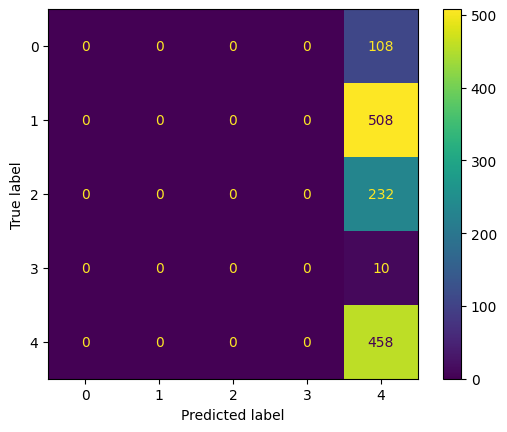

In [24]:
from sklearn.model_selection import train_test_split
train_data=os.listdir("/content/drive/MyDrive/DL_project/TRAIN")
all_paths=[]
all_labels=[]
for i,path in enumerate(train_data):
    full_path="/content/drive/MyDrive/DL_project/TEST/"+"TEST_"+path[-1]+"/"
    lst=os.listdir(full_path)
    lst=[full_path+i for i in lst]
    all_paths.extend(lst)
    all_labels.extend([i for j in range(len(lst))])
all_paths=np.array(all_paths)
all_labels=np.array(all_labels)
test_dataset=DataSet(all_paths,all_labels,trans)
test_loader=DataLoader(test_dataset,batch_size=12,shuffle=True)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
model.eval()
with torch.no_grad():
    total_loss = 0
    test_acc=0
    test_prec=0
    test_f1=0
    testing_pred=None
    testing_out=None
    for i,(inputs, targets) in tqdm(enumerate(test_loader)):
        outputs = model(inputs)
        targets=targets.to(torch.long)
        targets=targets.to('cpu')
        outputs=outputs.to('cpu')
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        outputs=torch.argmax(outputs,dim=1)
        test_acc+=get_acc(outputs,targets)
        test_prec+=get_prec(outputs,targets)
        test_f1+=get_f1(outputs,targets)
        if(testing_pred is None):
            testing_pred=np.array(outputs)
            testing_out=np.array(targets)
        else:
            testing_pred=np.concatenate([testing_pred,np.array(outputs)],axis=0)
            testing_out=np.concatenate([testing_out,np.array(targets)],axis=0)        
    test_acc/=(i+1)
    total_loss/=(i+1)
    test_prec/=(i+1)
    test_f1/=(i+1)
    sen = f"Testing ,Running Loss {total_loss} ,Accuracy:{test_acc},Precision:{test_prec},F1:{test_f1}"
    print(sen)
    cm = confusion_matrix(testing_out,testing_pred, labels=[i for i in range(5)])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[i for i in range(5)])
    disp.plot()
    plt.show()

In [27]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(testing_out,testing_pred)
print("Kappa score:", kappa)

Kappa score: 0.0
